# Examining False Positives from DR5

In [1]:
%matplotlib notebook

In [46]:
# imports
import pdb
from matplotlib import pyplot as plt

from astropy import units as u

from specdb.specdb import IgmSpec

from pyigm.surveys import dlasurvey as pyi_dla
from pyigm.abssys.utils import hi_model

sys.path.append(os.path.abspath("../../src"))
import vette_results as vetter

## IGMSpec

In [44]:
igmsp = IgmSpec()

## Load SDSS DR5

In [8]:
sdss = pyi_dla.DLASurvey.load_SDSS_DR5()

SDSS-DR5: Loading DLA file /Users/xavier/local/Python/pyigm/pyigm/data/DLA/SDSS_DR5/dr5_alldla.fits.gz
SDSS-DR5: Loading QSOs file /Users/xavier/local/Python/pyigm/pyigm/data/DLA/SDSS_DR5/dr5_dlagz_s2n4.fits
SDSS-DR5: Performing stats
SDSS-DR5: Loaded


In [9]:
sdss

<IGMSurvey: nsys=737, type=DLA, ref=SDSS-DR5 (PW09), nsightlines=7482>

### For vetting

In [12]:
sdss_all = pyi_dla.DLASurvey.load_SDSS_DR5(sample='all_sys')
s_coord = sdss_all.coord
s_zabs = sdss_all.zabs

SDSS-DR5: Loading DLA file /Users/xavier/local/Python/pyigm/pyigm/data/DLA/SDSS_DR5/dr5_alldla.fits.gz


/Users/xavier/local/Python/pyigm/pyigm/surveys/dlasurvey.py:174: UserWarning: Loading an LLSSurvey not a DLASurvey
  dla_survey.ref = 'SDSS-DR5 (PW09)'


SDSS-DR5: Loading QSOs file /Users/xavier/local/Python/pyigm/pyigm/data/DLA/SDSS_DR5/dr5_dlagz_s2n4.fits


In [13]:
np.min(sdss_all.NHI)

18.550000000000001

In [30]:
def chk_against_sdss(isys):
    gdsep = isys.coord.separation(s_coord) < 2*u.arcsec
    gdz = np.abs(s_zabs-isys.zabs) < 0.1
    # 
    match = gdsep & gdz
    if np.sum(match) == 0:
        print("No match in JXP DR5")
        return
    for ii in np.where(match)[0]:
        #pdb.set_trace()
        print("Matched to {}".format(sdss_all._abs_sys[ii]))

In [75]:
# Show DLA
def plot_dla(dla, wvoff=40.):
    # Get spectrum
    all_spec, all_meta = igmsp.allspec_at_coord(dla.coord, groups=['SDSS_DR7'])
    spec = all_spec[0]
    # Get wavelength limits
    wvcen = (1+dla.zabs)*1215.67
    gd_wv = (spec.wavelength.value > wvcen-wvoff) & (spec.wavelength.value < wvcen+wvoff)
    # Continuum?
    use_co = False
    if spec.co_is_set:
        use_co = True
        if spec.co[0] != 1.:
            use_co = False
    if use_co:
        mxco = np.max(spec.co[gd_wv])
        co = self.co
    else:
        mxco = np.max(spec.flux[gd_wv])
        co = mxco
    # Create DLA
    lya, lines = hi_model(dla, spec, lya_only=True)
    # Plot
    plt.clf()
    ax = plt.gca()
    ax.plot(spec.wavelength, spec.flux, 'k', drawstyle='steps-mid')
    ax.plot(spec.wavelength, spec.sig, 'r:')
    # Model
    ax.plot(lya.wavelength, lya.flux*co, 'g') # model
    if use_co:
        ax.plot(spec.wavelength, spec.co, '--', color='gray')
    # Axes
    ax.set_xlim(wvcen-wvoff, wvcen+wvoff)
    ax.set_ylim(-0.1*mxco, mxco*1.1)
    plt.show()

## v2 of gensample

In [16]:
ml_survey = vetter.json_to_sdss_dlasurvey('../../results/results_catalog_dr7_model_gensample_v2.json',sdss)

Loading SDSS Survey from JSON file ../../results/results_catalog_dr7_model_gensample_v2.json
Sightline RA=260.254 deg, DEC=53.4094 deg was not used
Sightline RA=151.445 deg, DEC=29.8916 deg was not used
Sightline RA=168.713 deg, DEC=39.6323 deg was not used
Sightline RA=128.336 deg, DEC=20.6529 deg was not used


In [17]:
false_neg, midx, false_pos = vetter.vette_dlasurvey(ml_survey, sdss)

/Users/xavier/local/Python/pyigm/pyigm/surveys/dlasurvey.py:423: UserWarning: Resetting mask to None.  Be careful here
  #zmax = ltu.z_from_dv(vprox, qsos['ZEM'])


Done cutting on Lyb


In [94]:
# Table for David
vetter.mk_false_neg_table(false_pos, '../../results/false_positives_DR5_v2_gen.csv')

Writing false negative file: ../../results/false_positives_DR5_v2_gen.csv


### Examine globally

In [8]:
len(false_pos)

300

In [22]:
# NHI
NHI = np.array([x.NHI for x in false_pos])

<IPython.core.display.Javascript object>


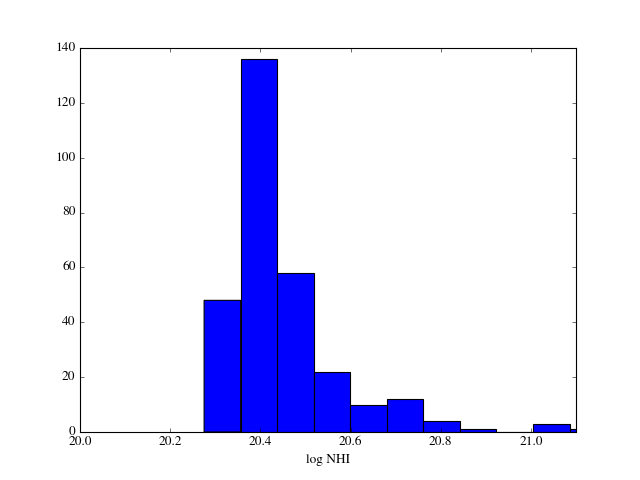

In [19]:
plt.clf()
ax = plt.gca()
ax.hist(NHI, bins=40)
ax.set_xlim(20., 21.1)
ax.set_xlabel('log NHI')
plt.show()

In [20]:
# z
z = [x.zabs for x in false_pos]

<IPython.core.display.Javascript object>


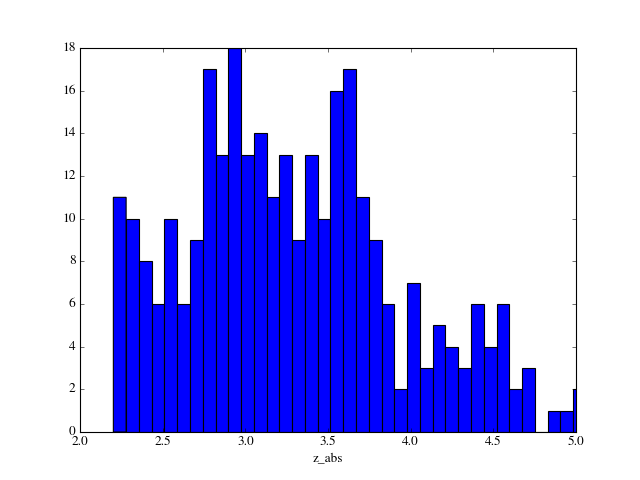

In [21]:
plt.clf()
ax = plt.gca()
ax.hist(z, bins=40)
ax.set_xlim(2., 5.)
ax.set_xlabel('z_abs')
plt.show()

### Examine a few individually

#### 0
    JXP identified a system there.  NHI just below DLA cut-off

In [27]:
idx = 0
false_pos[idx]

<LLSSystem: 10:36:12.9456 +00:11:00.0357, zabs=2.92902, logNHI=20.4154, tau_LL=1649.84, [Z/H]=0 dex>

In [28]:
chk_against_sdss(false_pos[idx])

Matched to <LLSSystem: 10:36:12.94 +00:11:00, zabs=2.9303, logNHI=20.2, tau_LL=1004.69, [Z/H]=0 dex>


#### 1, 2, 3
    Low S/N data
    No matches to JXP

In [31]:
idx = 1
print(false_pos[idx])
chk_against_sdss(false_pos[idx])

<LLSSystem: 11:08:19.1592 -00:58:23.9532, zabs=4.02093, logNHI=20.5034, tau_LL=2020.54, [Z/H]=0 dex>
No match in JXP DR5


#### 4
    Match to low NHI in JXP

In [36]:
idx = 4
print(false_pos[idx])
chk_against_sdss(false_pos[idx])

<LLSSystem: 11:14:01.4736 -00:53:21.1522, zabs=4.26241, logNHI=20.4069, tau_LL=1617.89, [Z/H]=0 dex>
Matched to <LLSSystem: 11:14:01.47 -00:53:21.2, zabs=4.26453, logNHI=20.05, tau_LL=711.266, [Z/H]=0 dex>


#### 5
    Plausible, low NHI DLA;  metals
    Missed entirey by JXP

In [37]:
idx = 5
print(false_pos[idx])
chk_against_sdss(false_pos[idx])

<LLSSystem: 12:38:21.672 +01:05:18.7098, zabs=2.53822, logNHI=20.3368, tau_LL=1376.65, [Z/H]=0 dex>
No match in JXP DR5


#### 6
    No JXP match
    Weak NHI; not likely a DLA

In [49]:
idx = 6
print(false_pos[idx])
chk_against_sdss(false_pos[idx])

<LLSSystem: 13:05:11.6328 -01:42:44.9496, zabs=3.51944, logNHI=20.3308, tau_LL=1357.73, [Z/H]=0 dex>
No match in JXP DR5


Your search yielded 1 match[es] within radius=0.5 arcsec
Staged 1 spectra totalling 9.3e-05 Gb
Loaded spectra
Staged 1 spectra totalling 6.4e-05 Gb
Loaded spectra


<IPython.core.display.Javascript object>


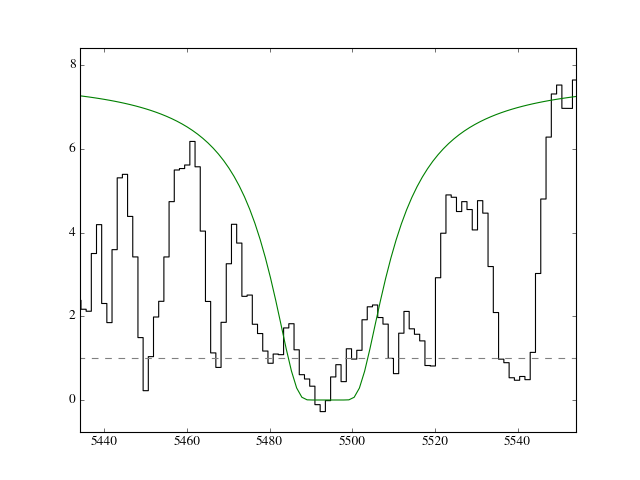

In [64]:
plot_dla(false_pos[idx], wvoff=60.)

#### 7
    Weak, very unlikely DLA

In [39]:
idx = 7
print(false_pos[idx])
chk_against_sdss(false_pos[idx])

<LLSSystem: 17:11:34.4208 +60:52:40.4904, zabs=3.63004, logNHI=20.3664, tau_LL=1473.7, [Z/H]=0 dex>
No match in JXP DR5


#### 8
    Matched to weak JXP system

In [40]:
idx = 8
print(false_pos[idx])
chk_against_sdss(false_pos[idx])

<LLSSystem: 17:18:00.2064 +62:13:25.662, zabs=3.6162, logNHI=20.3818, tau_LL=1527.12, [Z/H]=0 dex>
Matched to <LLSSystem: 17:18:00.19 +62:13:25.7, zabs=3.61876, logNHI=20.2, tau_LL=1004.69, [Z/H]=0 dex>


#### 9
    Junk

In [65]:
idx = 9
print(false_pos[idx])
chk_against_sdss(false_pos[idx])

<LLSSystem: 17:18:08.6688 +55:15:11.2104, zabs=4.31232, logNHI=20.4365, tau_LL=1731.92, [Z/H]=0 dex>
No match in JXP DR5


Your search yielded 1 match[es] within radius=0.5 arcsec
Staged 1 spectra totalling 6.4e-05 Gb
Loaded spectra


<IPython.core.display.Javascript object>


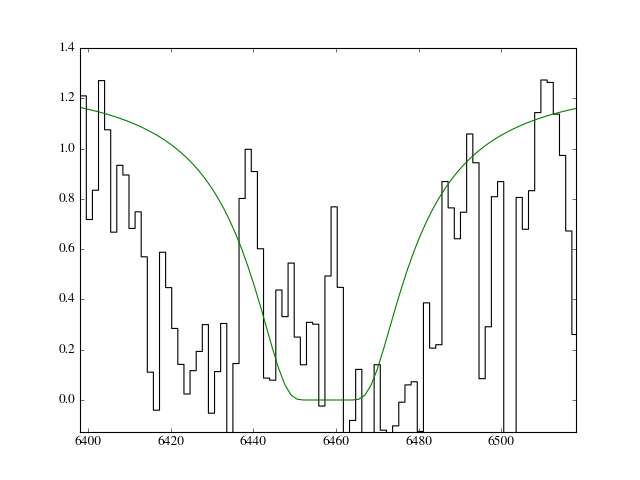

In [70]:
plot_dla(false_pos[idx], wvoff=60.)

#### 10
    More junk (flux spike)

In [71]:
idx = 10
print(false_pos[idx])
chk_against_sdss(false_pos[idx])

<LLSSystem: 22:00:08.6616 +00:17:44.8417, zabs=4.49394, logNHI=20.4172, tau_LL=1656.54, [Z/H]=0 dex>
No match in JXP DR5


Your search yielded 1 match[es] within radius=0.5 arcsec
Staged 1 spectra totalling 6.4e-05 Gb
Loaded spectra


<IPython.core.display.Javascript object>


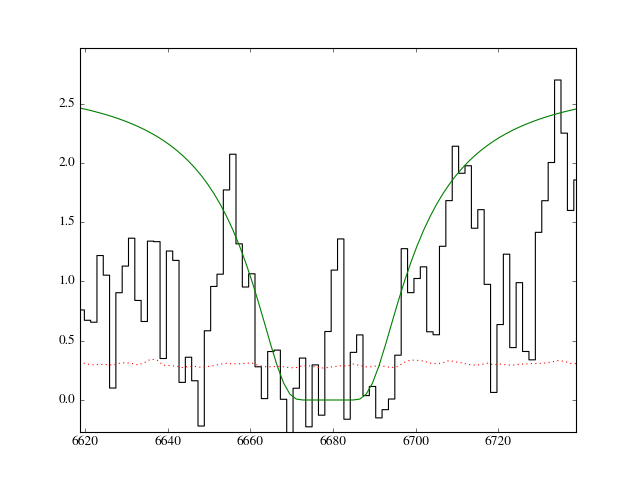

In [76]:
plot_dla(false_pos[idx], wvoff=60.)

#### 11, 12
    Low S/N
    Could be real

In [77]:
idx = 11
print(false_pos[idx])
chk_against_sdss(false_pos[idx])

<LLSSystem: 23:41:47.2704 +00:15:51.9422, zabs=3.35296, logNHI=20.6899, tau_LL=3104.18, [Z/H]=0 dex>
No match in JXP DR5


Your search yielded 1 match[es] within radius=0.5 arcsec
Staged 1 spectra totalling 6.4e-05 Gb
Loaded spectra


<IPython.core.display.Javascript object>


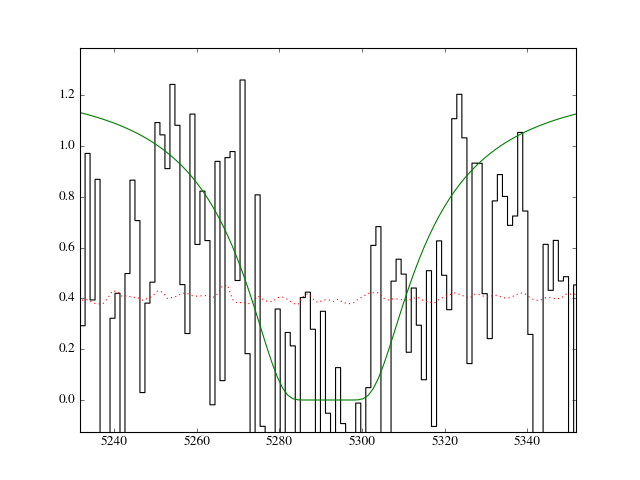

In [78]:
plot_dla(false_pos[idx], wvoff=60.)

#### 13
    Plausible; likely metals

In [81]:
idx = 13
print(false_pos[idx])
chk_against_sdss(false_pos[idx])

<LLSSystem: 02:46:14.5406 +00:54:27.3445, zabs=2.46086, logNHI=20.4073, tau_LL=1619.19, [Z/H]=0 dex>
No match in JXP DR5


Your search yielded 1 match[es] within radius=0.5 arcsec
Staged 1 spectra totalling 6.4e-05 Gb
Loaded spectra


<IPython.core.display.Javascript object>


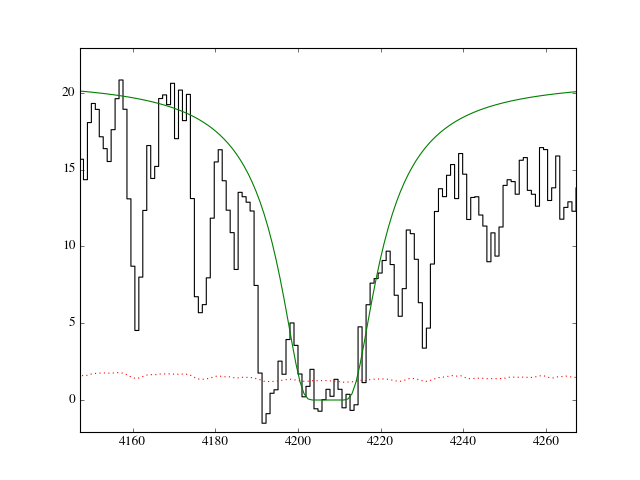

In [82]:
plot_dla(false_pos[idx], wvoff=60.)

#### 14

In [83]:
idx = 14
print(false_pos[idx])
chk_against_sdss(false_pos[idx])

<LLSSystem: 03:10:36.8518 +00:55:21.5968, zabs=3.11798, logNHI=20.3823, tau_LL=1528.63, [Z/H]=0 dex>
Matched to <LLSSystem: 03:10:36.84 +00:55:21.7, zabs=3.11418, logNHI=20.2, tau_LL=1004.69, [Z/H]=0 dex>


#### 15

In [84]:
idx = 15
print(false_pos[idx])
chk_against_sdss(false_pos[idx])

<LLSSystem: 03:14:52.0699 +00:13:46.4084, zabs=2.63567, logNHI=20.3315, tau_LL=1360.07, [Z/H]=0 dex>
Matched to <LLSSystem: 03:14:52.06 +00:13:46.3, zabs=2.63451, logNHI=20.15, tau_LL=895.431, [Z/H]=0 dex>


#### 16
    Strong absorber
    But NHI < 20.3

In [85]:
idx = 16
print(false_pos[idx])
chk_against_sdss(false_pos[idx])

<LLSSystem: 03:38:54.7721 -00:05:20.9027, zabs=2.74701, logNHI=20.3821, tau_LL=1527.94, [Z/H]=0 dex>
No match in JXP DR5


Your search yielded 1 match[es] within radius=0.5 arcsec
Staged 1 spectra totalling 6.4e-05 Gb
Loaded spectra


<IPython.core.display.Javascript object>


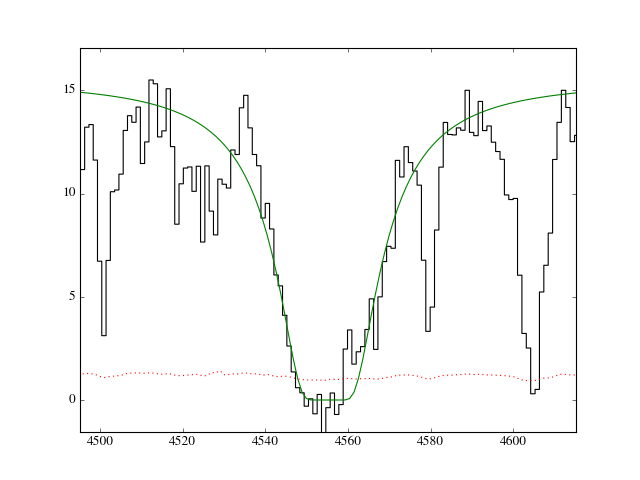

In [86]:
plot_dla(false_pos[idx], wvoff=60.)

#### 17

In [87]:
idx = 17
print(false_pos[idx])
chk_against_sdss(false_pos[idx])

<LLSSystem: 01:33:17.7883 +14:43:00.4368, zabs=2.97543, logNHI=20.3791, tau_LL=1517.53, [Z/H]=0 dex>
Matched to <LLSSystem: 01:33:17.79 +14:43:00.3, zabs=2.97657, logNHI=20.15, tau_LL=895.431, [Z/H]=0 dex>


#### 18

In [88]:
idx = 18
print(false_pos[idx])
chk_against_sdss(false_pos[idx])

<LLSSystem: 08:03:36.3744 +43:27:57.3948, zabs=2.77124, logNHI=20.4358, tau_LL=1729.23, [Z/H]=0 dex>
Matched to <LLSSystem: 08:03:36.37 +43:27:57.3, zabs=2.76877, logNHI=20.2, tau_LL=1004.69, [Z/H]=0 dex>


#### 19
    Low S/N
    Could be legit

In [90]:
idx = 19
print(false_pos[idx])
chk_against_sdss(false_pos[idx])

<LLSSystem: 08:12:41.1216 +44:21:29.016, zabs=4.17707, logNHI=20.4333, tau_LL=1719.37, [Z/H]=0 dex>
No match in JXP DR5


Your search yielded 1 match[es] within radius=0.5 arcsec
Staged 1 spectra totalling 6.4e-05 Gb
Loaded spectra


<IPython.core.display.Javascript object>


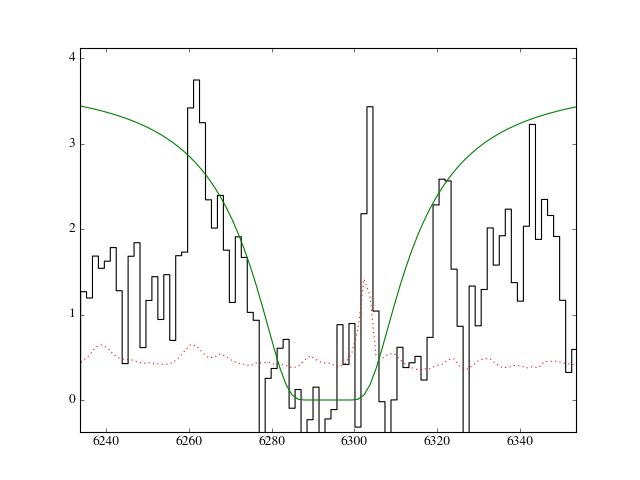

In [91]:
plot_dla(false_pos[idx], wvoff=60.)

#### 20

In [92]:
idx = 20
print(false_pos[idx])
chk_against_sdss(false_pos[idx])

<LLSSystem: 08:31:03.0048 +52:35:33.6372, zabs=4.18065, logNHI=20.4075, tau_LL=1620.1, [Z/H]=0 dex>
Matched to <LLSSystem: 08:31:03.01 +52:35:33.5, zabs=4.16845, logNHI=20.1, tau_LL=798.054, [Z/H]=0 dex>
